In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os


ROOT = "/content/drive/MyDrive/Tracefinder"

print("Root contents:", os.listdir(ROOT))
print("Flatfield scanners:", os.listdir(os.path.join(ROOT, "Flatfield")))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Root contents: ['Flatfield', 'Originals', 'Official', 'Wikipedia', 'Tampered images', 'tracefinder_manifest_preprocessed.csv', 'tracefinder_manifest.csv']
Flatfield scanners: ['Canon120-1', 'EpsonV39-1', 'Canon120-2', 'Canon220', 'HP', 'EpsonV370-2', 'EpsonV39-2', 'Canon9000-1', 'EpsonV550', 'EpsonV370-1', 'Canon9000-2']


In [8]:



import os
import cv2
import numpy as np
import pandas as pd
import tifffile
from tifffile import TiffFileError
from scipy.stats import skew


ROOT = "/content/drive/MyDrive/Tracefinder"
flatfield_root = os.path.join(ROOT, "Flatfield")

print("Flatfield scanners:", os.listdir(flatfield_root))


def image_entropy(img):
    """Compute Shannon entropy of a grayscale image."""
    img_uint8 = img if img.dtype == np.uint8 else (
        (255 * (img - img.min()) / (img.max() - img.min() + 1e-8)).astype("uint8")
    )

    hist, _ = np.histogram(img_uint8, bins=256, range=(0,255))
    p = hist.astype(float) / (hist.sum() + 1e-8)

    nz = p > 0
    return float(-np.sum(p[nz] * np.log2(p[nz])))


def load_flatfield_gray(path):
    """Read TIFF safely → return grayscale 8-bit image."""
    try:
        img = tifffile.imread(path)
    except Exception as e:
        print(f"[WARN] tifffile failed for {path}: {e}")
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

    if img is None:
        raise ValueError(f"Could not load: {path}")

    # 16-bit → 8-bit
    if img.dtype == np.uint16:
        img = (img / 256).astype("uint8")

    # RGB → Gray
    if img.ndim == 3:
        if img.shape[2] in (3,4):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img = img.mean(axis=2).astype("uint8")

    if img.ndim != 2:
        raise ValueError(f"Not grayscale after conversion: {path}")

    return img


flatfield_paths = []
for scanner_id in os.listdir(flatfield_root):
    scanner_dir = os.path.join(flatfield_root, scanner_id)
    if not os.path.isdir(scanner_dir):
        continue

    for fname in os.listdir(scanner_dir):
        if fname.lower().endswith(".tif"):
            dpi = os.path.splitext(fname)[0]   # "150" or "300"
            path = os.path.join(scanner_dir, fname)
            flatfield_paths.append((scanner_id, dpi, path))

print(f"Found {len(flatfield_paths)} flatfield TIFF files.")


flat_stats = []
bad_files = []

for scanner_id, dpi, path in flatfield_paths:
    try:
        img = load_flatfield_gray(path)
    except Exception as e:
        print(f"[ERROR] Skipping {path}: {e}")
        bad_files.append((scanner_id, dpi, path, str(e)))
        continue

    h, w = img.shape
    flat_stats.append({
        "scanner_id": scanner_id,
        "dpi": dpi,
        "path": path,
        "width": w,
        "height": h,
        "mean": float(img.mean()),
        "std": float(img.std()),
        "min": int(img.min()),
        "max": int(img.max()),
        "entropy": image_entropy(img),
        "skewness": float(skew(img.astype("float32").ravel())),
    })


# ---------------- OUTPUT ----------------
df_flat = pd.DataFrame(flat_stats)

print("\n=== FLATFIELD EXPLORATION TABLE ===")
display(df_flat)

print("\n=== BAD / CORRUPTED FILES (if any) ===")
bad_files


Flatfield scanners: ['Canon120-1', 'EpsonV39-1', 'Canon120-2', 'Canon220', 'HP', 'EpsonV370-2', 'EpsonV39-2', 'Canon9000-1', 'EpsonV550', 'EpsonV370-1', 'Canon9000-2']
Found 23 flatfield TIFF files.
[WARN] tifffile failed for /content/drive/MyDrive/Tracefinder/Flatfield/EpsonV39-1/._150.tif: not a TIFF file b'\x00\x05\x16\x07'
[ERROR] Skipping /content/drive/MyDrive/Tracefinder/Flatfield/EpsonV39-1/._150.tif: Could not load: /content/drive/MyDrive/Tracefinder/Flatfield/EpsonV39-1/._150.tif

=== FLATFIELD EXPLORATION TABLE ===


,scanner_id,dpi,path,width,height,mean,std,min,max,entropy,skewness
0,Canon120-1,300,/content/drive/MyDrive/Tracefinder/Flatfield/C...,2480,3508,254.998784,0.179141,86,255,0.002581,-332.398346
1,Canon120-1,150,/content/drive/MyDrive/Tracefinder/Flatfield/C...,1240,1752,254.999216,0.130889,151,255,0.002176,-384.556915
2,EpsonV39-1,300,/content/drive/MyDrive/Tracefinder/Flatfield/E...,2480,3508,254.997431,0.184865,199,255,0.010643,-143.349106
3,EpsonV39-1,150,/content/drive/MyDrive/Tracefinder/Flatfield/E...,1240,1754,254.998722,0.131475,209,255,0.004157,-178.971039
4,Canon120-2,300,/content/drive/MyDrive/Tracefinder/Flatfield/C...,2480,3508,254.678483,7.898634,32,255,0.039482,-26.104301
5,Canon120-2,150,/content/drive/MyDrive/Tracefinder/Flatfield/C...,2480,3508,254.679930,7.874533,32,255,0.039158,-26.121939
6,Canon220,300,/content/drive/MyDrive/Tracefinder/Flatfield/C...,2480,3508,254.650592,8.604972,26,255,0.032442,-25.318676
7,Canon220,150,/content/drive/MyDrive/Tracefinder/Flatfield/C...,1240,1752,254.614799,9.017369,26,255,0.033290,-24.108482
8,HP,300,/content/drive/MyDrive/Tracefinder/Flatfield/H...,2480,3503,252.466709,0.767535,189,255,1.609911,-1.014381
9,HP,150,/content/drive/MyDrive/Tracefinder/Flatfield/H...,1240,1743,253.779135,0.555860,224,255,1.156231,-1.355424



=== BAD / CORRUPTED FILES (if any) ===


[('EpsonV39-1',
  '._150',
  '/content/drive/MyDrive/Tracefinder/Flatfield/EpsonV39-1/._150.tif',
  'Could not load: /content/drive/MyDrive/Tracefinder/Flatfield/EpsonV39-1/._150.tif')]

In [9]:
results_folder = os.path.join(ROOT, "Results")
os.makedirs(results_folder, exist_ok=True)

save_path = os.path.join(results_folder, "flatfield_exploration.csv")
df_flat.to_csv(save_path, index=False)

print("Saved CSV to:", save_path)


Saved CSV to: /content/drive/MyDrive/Tracefinder/Results/flatfield_exploration.csv


In [10]:


import os
import cv2
import numpy as np
import pandas as pd
import tifffile
from scipy.stats import skew


official_root = os.path.join(ROOT, "Official")


def load_gray(path):
    """Safely load TIFF → grayscale 8-bit."""
    try:
        img = tifffile.imread(path)
    except:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

    if img is None:
        raise ValueError(f"Cannot read {path}")

    if img.dtype == np.uint16:
        img = (img / 256).astype("uint8")

    if img.ndim == 3:
        if img.shape[2] in (3,4):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img = img.mean(axis=2).astype("uint8")

    return img


def image_entropy(img):
    if img.dtype != np.uint8:
        img = (255 * (img - img.min()) / (img.max() - img.min() + 1e-8)).astype("uint8")

    hist, _ = np.histogram(img, bins=256, range=(0,255))
    p = hist.astype(float) / (hist.sum() + 1e-8)
    nz = p > 0
    return float(-np.sum(p[nz] * np.log2(p[nz])))


sample_paths = []
for scanner_id in os.listdir(official_root):
    scanner_dir = os.path.join(official_root, scanner_id, "300")
    if not os.path.isdir(scanner_dir):
        continue

    tif_files = [f for f in os.listdir(scanner_dir) if f.lower().endswith(".tif")]
    tif_files = sorted(tif_files)[:3]  # first three files

    for fname in tif_files:
        path = os.path.join(scanner_dir, fname)
        sample_paths.append((scanner_id, path))

print(f"Total sampled images: {len(sample_paths)}")


official_stats = []
bad_files = []

for scanner_id, path in sample_paths:
    try:
        img = load_gray(path)
    except Exception as e:
        print(f"[ERROR] Skipping {path}: {e}")
        bad_files.append((scanner_id, path, str(e)))
        continue

    h, w = img.shape

    official_stats.append({
        "scanner_id": scanner_id,
        "path": path,
        "width": w,
        "height": h,
        "mean": float(img.mean()),
        "std": float(img.std()),
        "min": int(img.min()),
        "max": int(img.max()),
        "entropy": image_entropy(img),
        "skewness": float(skew(img.astype("float32").ravel())),
    })


df_official = pd.DataFrame(official_stats)

print("\n=== OFFICIAL 300 DPI SAMPLE EXPLORATION ===")
display(df_official)

print("\n=== BAD / CORRUPTED OFFICIAL FILES ===")
bad_files


Total sampled images: 33

=== OFFICIAL 300 DPI SAMPLE EXPLORATION ===


,scanner_id,path,width,height,mean,std,min,max,entropy,skewness
0,Canon120-1,/content/drive/MyDrive/Tracefinder/Official/Ca...,2480,3508,247.297242,33.717641,38,255,1.975895,-4.843520
1,Canon120-1,/content/drive/MyDrive/Tracefinder/Official/Ca...,2480,3508,246.922217,33.347827,35,255,1.753208,-4.394793
2,Canon120-1,/content/drive/MyDrive/Tracefinder/Official/Ca...,2480,3508,250.933460,24.373627,34,255,1.376626,-7.000412
3,Canon220,/content/drive/MyDrive/Tracefinder/Official/Ca...,2480,3508,247.225394,32.707325,41,255,2.245888,-4.786728
4,Canon220,/content/drive/MyDrive/Tracefinder/Official/Ca...,2480,3508,246.957957,32.235146,30,255,1.983898,-4.330463
5,Canon220,/content/drive/MyDrive/Tracefinder/Official/Ca...,2480,3508,250.729819,24.320535,27,255,1.574703,-6.791056
6,EpsonV370-2,/content/drive/MyDrive/Tracefinder/Official/Ep...,2480,3508,244.287447,33.671094,45,255,3.788314,-4.514040
7,EpsonV370-2,/content/drive/MyDrive/Tracefinder/Official/Ep...,2480,3508,244.530976,33.212004,33,255,3.493280,-4.039811
8,EpsonV370-2,/content/drive/MyDrive/Tracefinder/Official/Ep...,2480,3508,248.286797,24.691154,31,255,3.315930,-6.127016
9,EpsonV370-1,/content/drive/MyDrive/Tracefinder/Official/Ep...,2480,3508,244.266328,33.787604,43,255,3.779332,-4.514277



=== BAD / CORRUPTED OFFICIAL FILES ===


[]

In [11]:

import os
import cv2
import numpy as np
import pandas as pd
import tifffile
from scipy.stats import skew

official_root = os.path.join(ROOT, "Official")

def load_gray(path):
    """Safely load image → grayscale 8-bit."""
    try:
        img = tifffile.imread(path)
    except:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

    if img is None:
        raise ValueError(f"Cannot read {path}")

    if img.dtype == np.uint16:
        img = (img / 256).astype("uint8")

    if img.ndim == 3:
        if img.shape[2] in (3,4):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img = img.mean(axis=2).astype("uint8")

    return img

def image_entropy(img):
    if img.dtype != np.uint8:
        img = (255 * (img - img.min()) / (img.max() - img.min() + 1e-8)).astype("uint8")

    hist, _ = np.histogram(img, bins=256, range=(0,255))
    p = hist.astype(float) / (hist.sum() + 1e-8)
    nz = p > 0
    return float(-np.sum(p[nz] * np.log2(p[nz])))


sample_paths_150 = []
for scanner_id in os.listdir(official_root):
    scanner_dir = os.path.join(official_root, scanner_id, "150")
    if not os.path.isdir(scanner_dir):
        continue

    tif_files = [f for f in os.listdir(scanner_dir) if f.lower().endswith(".tif")]
    tif_files = sorted(tif_files)[:3]

    for fname in tif_files:
        path = os.path.join(scanner_dir, fname)
        sample_paths_150.append((scanner_id, path))

print(f"Total sampled Official/150 images: {len(sample_paths_150)}")

official150_stats = []
bad_off150 = []

for scanner_id, path in sample_paths_150:
    try:
        img = load_gray(path)
    except Exception as e:
        print(f"[ERROR] Skipping {path}: {e}")
        bad_off150.append((scanner_id, path, str(e)))
        continue

    h, w = img.shape
    official150_stats.append({
        "scanner_id": scanner_id,
        "path": path,
        "width": w,
        "height": h,
        "mean": float(img.mean()),
        "std": float(img.std()),
        "min": int(img.min()),
        "max": int(img.max()),
        "entropy": image_entropy(img),
        "skewness": float(skew(img.astype("float32").ravel())),
    })

df_official_150 = pd.DataFrame(official150_stats)

print("\n=== OFFICIAL 150 DPI SAMPLE EXPLORATION ===")
display(df_official_150)

print("\n=== BAD / CORRUPTED OFFICIAL 150 FILES ===")
bad_off150


Total sampled Official/150 images: 33

=== OFFICIAL 150 DPI SAMPLE EXPLORATION ===


,scanner_id,path,width,height,mean,std,min,max,entropy,skewness
0,Canon120-1,/content/drive/MyDrive/Tracefinder/Official/Ca...,1240,1752,247.614713,32.865880,49,255,1.470899,-4.792071
1,Canon120-1,/content/drive/MyDrive/Tracefinder/Official/Ca...,1240,1752,247.182472,32.053725,39,255,1.271316,-4.202843
2,Canon120-1,/content/drive/MyDrive/Tracefinder/Official/Ca...,1240,1752,251.239591,23.295660,37,255,0.767753,-6.951853
3,Canon220,/content/drive/MyDrive/Tracefinder/Official/Ca...,1240,1752,247.705898,31.989412,47,255,1.812219,-4.818206
4,Canon220,/content/drive/MyDrive/Tracefinder/Official/Ca...,1240,1752,247.435333,31.077498,32,255,1.553059,-4.308692
5,Canon220,/content/drive/MyDrive/Tracefinder/Official/Ca...,1240,1752,251.095864,23.287464,27,255,1.176414,-6.919406
6,EpsonV370-2,/content/drive/MyDrive/Tracefinder/Official/Ep...,1236,1754,245.716136,32.217642,49,255,3.238205,-4.580421
7,EpsonV370-2,/content/drive/MyDrive/Tracefinder/Official/Ep...,1236,1754,245.844525,31.983168,36,255,2.809803,-4.051718
8,EpsonV370-2,/content/drive/MyDrive/Tracefinder/Official/Ep...,1236,1754,249.460073,23.515411,38,255,2.712470,-6.235666
9,EpsonV370-1,/content/drive/MyDrive/Tracefinder/Official/Ep...,1236,1754,245.846845,32.381004,51,255,3.152921,-4.584943



=== BAD / CORRUPTED OFFICIAL 150 FILES ===


[]

In [12]:


import os
import pandas as pd

print("Rows in 300 DPI table:", len(df_official))
print("Rows in 150 DPI table:", len(df_official_150))

if "dpi" not in df_official.columns:
    df_official["dpi"] = "300"

if "dpi" not in df_official_150.columns:
    df_official_150["dpi"] = "150"

df_official_all = pd.concat([df_official, df_official_150], ignore_index=True)

print("Total rows in combined table:", len(df_official_all))

save_path = os.path.join(ROOT, "official_exploration.csv")
df_official_all.to_csv(save_path, index=False)

print("\nSaved combined CSV to:", save_path)
display(df_official_all.head())


Rows in 300 DPI table: 33
Rows in 150 DPI table: 33
Total rows in combined table: 66

Saved combined CSV to: /content/drive/MyDrive/Tracefinder/official_exploration.csv


,scanner_id,path,width,height,mean,std,min,max,entropy,skewness,dpi
0,Canon120-1,/content/drive/MyDrive/Tracefinder/Official/Ca...,2480,3508,247.297242,33.717641,38,255,1.975895,-4.843520,300
1,Canon120-1,/content/drive/MyDrive/Tracefinder/Official/Ca...,2480,3508,246.922217,33.347827,35,255,1.753208,-4.394793,300
2,Canon120-1,/content/drive/MyDrive/Tracefinder/Official/Ca...,2480,3508,250.933460,24.373627,34,255,1.376626,-7.000412,300
3,Canon220,/content/drive/MyDrive/Tracefinder/Official/Ca...,2480,3508,247.225394,32.707325,41,255,2.245888,-4.786728,300
4,Canon220,/content/drive/MyDrive/Tracefinder/Official/Ca...,2480,3508,246.957957,32.235146,30,255,1.983898,-4.330463,300


In [13]:


wikipedia_root = os.path.join(ROOT, "Wikipedia")

def load_gray_wiki(path):
    """Same loader as before, just separate name for clarity."""
    try:
        img = tifffile.imread(path)
    except:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

    if img is None:
        raise ValueError(f"Cannot read {path}")

    if img.dtype == np.uint16:
        img = (img / 256).astype("uint8")

    if img.ndim == 3:
        if img.shape[2] in (3,4):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img = img.mean(axis=2).astype("uint8")

    return img


def image_entropy_wiki(img):
    if img.dtype != np.uint8:
        img = (255 * (img - img.min()) / (img.max() - img.min() + 1e-8)).astype("uint8")

    hist, _ = np.histogram(img, bins=256, range=(0,255))
    p = hist.astype(float) / (hist.sum() + 1e-8)
    nz = p > 0
    return float(-np.sum(p[nz] * np.log2(p[nz])))


sample_paths_wiki = []
for scanner_id in os.listdir(wikipedia_root):
    for dpi in ["150", "300"]:
        scanner_dir = os.path.join(wikipedia_root, scanner_id, dpi)
        if not os.path.isdir(scanner_dir):
            continue

        tif_files = [f for f in os.listdir(scanner_dir) if f.lower().endswith(".tif")]
        tif_files = sorted(tif_files)[:3]

        for fname in tif_files:
            path = os.path.join(scanner_dir, fname)
            sample_paths_wiki.append((scanner_id, dpi, path))

print(f"Total sampled Wikipedia images: {len(sample_paths_wiki)}")

wiki_stats = []
bad_wiki = []

for scanner_id, dpi, path in sample_paths_wiki:
    try:
        img = load_gray_wiki(path)
    except Exception as e:
        print(f"[ERROR] Skipping {path}: {e}")
        bad_wiki.append((scanner_id, dpi, path, str(e)))
        continue

    h, w = img.shape
    wiki_stats.append({
        "scanner_id": scanner_id,
        "dpi": dpi,
        "path": path,
        "width": w,
        "height": h,
        "mean": float(img.mean()),
        "std": float(img.std()),
        "min": int(img.min()),
        "max": int(img.max()),
        "entropy": image_entropy_wiki(img),
        "skewness": float(skew(img.astype("float32").ravel())),
    })

df_wiki = pd.DataFrame(wiki_stats)

print("\n=== WIKIPEDIA 150 & 300 DPI SAMPLE EXPLORATION ===")
display(df_wiki)

print("\n=== BAD / CORRUPTED WIKIPEDIA FILES ===")
bad_wiki


Total sampled Wikipedia images: 66

=== WIKIPEDIA 150 & 300 DPI SAMPLE EXPLORATION ===


,scanner_id,dpi,path,width,height,mean,std,min,max,entropy,skewness
0,EpsonV39-2,150,/content/drive/MyDrive/Tracefinder/Wikipedia/E...,1240,1754,244.960992,33.126875,46,255,2.441199,-3.898258
1,EpsonV39-2,150,/content/drive/MyDrive/Tracefinder/Wikipedia/E...,1240,1754,243.199345,35.159661,45,255,2.438070,-3.560696
2,EpsonV39-2,150,/content/drive/MyDrive/Tracefinder/Wikipedia/E...,1240,1754,242.365514,36.233450,46,255,2.607611,-3.431690
3,EpsonV39-2,300,/content/drive/MyDrive/Tracefinder/Wikipedia/E...,2480,3508,243.994058,36.371135,40,255,2.779623,-3.872473
4,EpsonV39-2,300,/content/drive/MyDrive/Tracefinder/Wikipedia/E...,2480,3508,242.561118,37.622801,34,255,2.658585,-3.567707
...,...,...,...,...,...,...,...,...,...,...,...
61,HP,150,/content/drive/MyDrive/Tracefinder/Wikipedia/H...,1240,1743,232.580548,34.302911,53,255,4.905482,-3.409181
62,HP,150,/content/drive/MyDrive/Tracefinder/Wikipedia/H...,1240,1743,232.087658,34.626750,61,255,5.000985,-3.287779
63,HP,300,/content/drive/MyDrive/Tracefinder/Wikipedia/H...,2481,3487,231.981481,33.657188,55,255,4.934677,-3.684633
64,HP,300,/content/drive/MyDrive/Tracefinder/Wikipedia/H...,2481,3487,229.770984,34.542476,57,255,5.169560,-3.328815



=== BAD / CORRUPTED WIKIPEDIA FILES ===


[]

In [14]:
save_path = os.path.join(ROOT, "wikipedia_exploration.csv")
df_wiki.to_csv(save_path, index=False)
print("Saved Wikipedia exploration CSV to:", save_path)


Saved Wikipedia exploration CSV to: /content/drive/MyDrive/Tracefinder/wikipedia_exploration.csv


flatfield preprocessing


In [15]:
import cv2
import tifffile
import numpy as np

def load_gray_8bit(path):
    """
    Safely load an image (TIFF or non-TIFF) as grayscale uint8.
    - tries tifffile first (best for TIFF)
    - falls back to cv2
    - converts 16-bit to 8-bit
    - converts RGB/CMYK/etc to grayscale
    """
    try:
        img = tifffile.imread(path)
    except Exception:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

    if img is None:
        raise ValueError(f"Could not read: {path}")

    # 16-bit -> 8-bit
    if img.dtype == np.uint16:
        img = (img / 256).astype("uint8")

    # RGB / CMYK → grayscale
    if img.ndim == 3:
        if img.shape[2] in (3, 4):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img = img.mean(axis=2).astype("uint8")

    if img.ndim != 2:
        raise ValueError(f"Unexpected shape after convert: {img.shape}")

    return img  # uint8 grayscale


In [16]:
FLAT_PATCH_SIZE = 512

def preprocess_flatfield(path):
    """
    Preprocess a flatfield:
    - load grayscale 8-bit
    - center crop 512x512 (NO RESIZING)
    - normalize to [0,1]
    Returns: patch, info
    """
    img = load_gray_8bit(path)
    h, w = img.shape

    crop_h = min(FLAT_PATCH_SIZE, h)
    crop_w = min(FLAT_PATCH_SIZE, w)

    start_y = (h - crop_h) // 2
    start_x = (w - crop_w) // 2

    patch = img[start_y:start_y+crop_h, start_x:start_x+crop_w]

    if patch.shape != (FLAT_PATCH_SIZE, FLAT_PATCH_SIZE):
        pad_y = FLAT_PATCH_SIZE - patch.shape[0]
        pad_x = FLAT_PATCH_SIZE - patch.shape[1]

        pad_top = pad_y // 2
        pad_bottom = pad_y - pad_top
        pad_left = pad_x // 2
        pad_right = pad_x - pad_left

        patch = cv2.copyMakeBorder(
            patch,
            pad_top, pad_bottom, pad_left, pad_right,
            borderType=cv2.BORDER_REFLECT_101
        )

    patch_norm = patch.astype("float32") / 255.0

    info = {
        "orig_shape": (h, w),
        "final_shape": patch_norm.shape,
        "path": path
    }

    return patch_norm, info


In [17]:
example_flat = "/content/drive/MyDrive/Tracefinder/Flatfield/Canon120-1/300.tif"

patch, details = preprocess_flatfield(example_flat)

print(details)
print("Patch min/max:", patch.min(), patch.max())


{'orig_shape': (3508, 2480), 'final_shape': (512, 512), 'path': '/content/drive/MyDrive/Tracefinder/Flatfield/Canon120-1/300.tif'}
Patch min/max: 0.9529412 1.0


In [35]:


import os
import pandas as pd

ROOT = "/content/drive/MyDrive/Tracefinder"
flatfield_root = os.path.join(ROOT, "Flatfield")

print("Flatfield root exists? ", os.path.exists(flatfield_root), "->", flatfield_root)
if os.path.exists(flatfield_root):
    print("Scanners in Flatfield:", os.listdir(flatfield_root))
else:
    print("⚠️ Flatfield folder not found. Check path/case in Drive.")

records = []


for scanner_id in sorted(os.listdir(flatfield_root)):
    scanner_dir = os.path.join(flatfield_root, scanner_id)
    if not os.path.isdir(scanner_dir):
        continue

    for fname in sorted(os.listdir(scanner_dir)):
        if fname.lower().endswith(".tif") or fname.lower().endswith(".tiff"):
            dpi = os.path.splitext(fname)[0]   # "150" or "300"
            path = os.path.join(scanner_dir, fname)
            records.append({
                "path": path,
                "scanner_id": scanner_id,
                "dpi": dpi,
            })

df_flat_idx = pd.DataFrame(records)
print("\nTotal flatfield images found:", len(df_flat_idx))
display(df_flat_idx.head())


if "scanner_to_label" in globals():
    print("\nReusing existing scanner_to_label mapping:")
    print(scanner_to_label)
else:

    unique_scanners_flat = sorted(df_flat_idx["scanner_id"].unique())
    scanner_to_label = {s: i for i, s in enumerate(unique_scanners_flat)}
    print("\nCreated new scanner_to_label mapping from flatfields:")
    print(scanner_to_label)

df_flat_idx["label_id"] = df_flat_idx["scanner_id"].map(scanner_to_label)

print("\nFlatfield index with label_id:")
display(df_flat_idx)


save_path = os.path.join(ROOT, "flatfield_index.csv")
df_flat_idx.to_csv(save_path, index=False)
print("\n✅ Saved flatfield index to:", save_path)


Flatfield root exists?  True -> /content/drive/MyDrive/Tracefinder/Flatfield
Scanners in Flatfield: ['Canon120-1', 'EpsonV39-1', 'Canon120-2', 'Canon220', 'HP', 'EpsonV370-2', 'EpsonV39-2', 'Canon9000-1', 'EpsonV550', 'EpsonV370-1', 'Canon9000-2']

Total flatfield images found: 23


,path,scanner_id,dpi
0,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon120-1,150
1,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon120-1,300
2,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon120-2,150
3,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon120-2,300
4,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon220,150



Reusing existing scanner_to_label mapping:
{'Canon120-1': 0, 'Canon120-2': 1, 'Canon220': 2, 'Canon9000-1': 3, 'Canon9000-2': 4, 'EpsonV370-1': 5, 'EpsonV370-2': 6, 'EpsonV39-1': 7, 'EpsonV39-2': 8, 'EpsonV550': 9, 'HP': 10}

Flatfield index with label_id:


,path,scanner_id,dpi,label_id
0,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon120-1,150,0
1,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon120-1,300,0
2,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon120-2,150,1
3,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon120-2,300,1
4,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon220,150,2
5,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon220,300,2
6,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon9000-1,150,3
7,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon9000-1,300,3
8,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon9000-2,150,4
9,/content/drive/MyDrive/Tracefinder/Flatfield/C...,Canon9000-2,300,4



✅ Saved flatfield index to: /content/drive/MyDrive/Tracefinder/flatfield_index.csv


official preprocessing

In [18]:
import os
import cv2
import tifffile
import numpy as np

ROOT = "/content/drive/MyDrive/Tracefinder"
official_root = os.path.join(ROOT, "Official")

def load_gray_8bit(path):
    """
    Safely load image as grayscale uint8.
    Handles:
      - tifffile + cv2 fallback
      - 16-bit → 8-bit
      - RGB/CMYK → grayscale
    """
    try:
        img = tifffile.imread(path)
    except Exception:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

    if img is None:
        raise ValueError(f"Could not read: {path}")

    if img.dtype == np.uint16:
        img = (img / 256).astype("uint8")

    if img.ndim == 3:
        if img.shape[2] in (3, 4):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img = img.mean(axis=2).astype("uint8")

    if img.ndim != 2:
        raise ValueError(f"Unexpected shape after conversion: {img.shape}")

    return img  # uint8, HxW


IMG_SIZE = (512, 512)

def preprocess_official(path):
    """
    Preprocess Official (150 or 300 DPI):
    - grayscale 8-bit
    - resize to 512x512
    - normalize [0,1]
    """
    img = load_gray_8bit(path)
    h, w = img.shape

    img_resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img_norm = img_resized.astype("float32") / 255.0

    info = {
        "path": path,
        "orig_shape": (h, w),
        "final_shape": img_norm.shape,
    }
    return img_norm, info

print("Official preprocessing ready.")


Official preprocessing ready.


In [19]:
import matplotlib.pyplot as plt

def show_original_vs_official(path, title="Official"):
    img_raw = load_gray_8bit(path)
    img_proc, info = preprocess_official(path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_raw, cmap="gray")
    axes[0].set_title(f"{title} ORIGINAL\n{img_raw.shape}")
    axes[0].axis("off")

    axes[1].imshow(img_proc, cmap="gray")
    axes[1].set_title(f"{title} PREPROCESSED\n{img_proc.shape}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    print("Info:", info)
    print("Raw min/max:", img_raw.min(), img_raw.max())
    print("Proc min/max:", img_proc.min(), img_proc.max())


Random 300 DPI file: /content/drive/MyDrive/Tracefinder/Official/Canon220/300/s3_1.tif


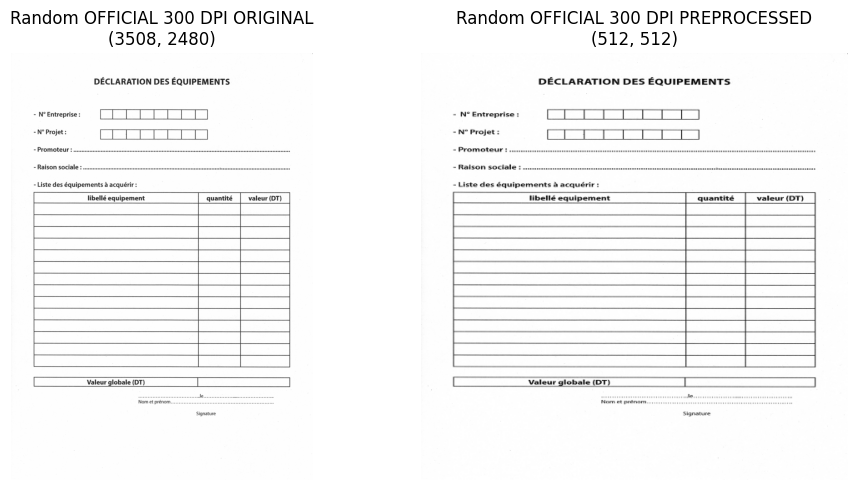

Info: {'path': '/content/drive/MyDrive/Tracefinder/Official/Canon220/300/s3_1.tif', 'orig_shape': (3508, 2480), 'final_shape': (512, 512)}
Raw min/max: 41 255
Proc min/max: 0.24313726 1.0


In [21]:
import random

def get_random_official(dpi):
    dpi_paths = []


    for scanner_id in os.listdir(official_root):
        dpi_dir = os.path.join(official_root, scanner_id, dpi)
        if not os.path.isdir(dpi_dir):
            continue

        tif_files = [f for f in os.listdir(dpi_dir) if f.lower().endswith(".tif")]
        for f in tif_files:
            dpi_paths.append(os.path.join(dpi_dir, f))


    return random.choice(dpi_paths)



random_300_path = get_random_official("300")
print("Random 300 DPI file:", random_300_path)

show_original_vs_official(random_300_path, title="Random OFFICIAL 300 DPI")


Random 150 DPI file: /content/drive/MyDrive/Tracefinder/Official/Canon120-1/150/s1_29.tif


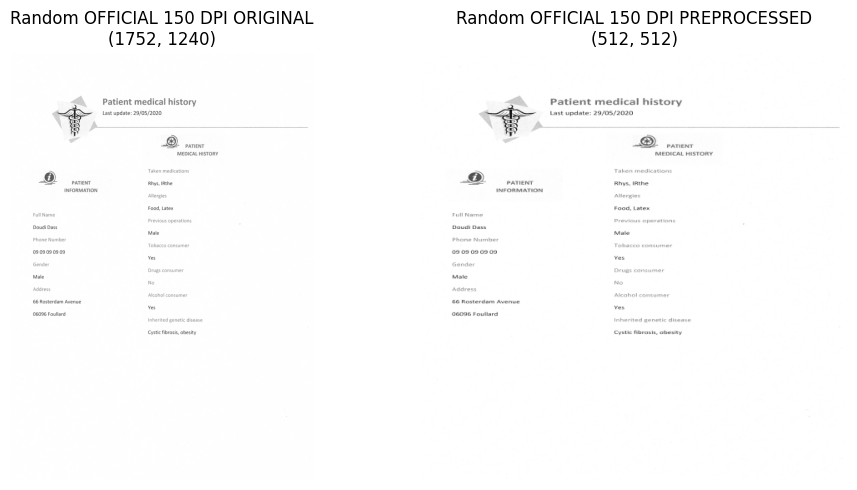

Info: {'path': '/content/drive/MyDrive/Tracefinder/Official/Canon120-1/150/s1_29.tif', 'orig_shape': (1752, 1240), 'final_shape': (512, 512)}
Raw min/max: 43 255
Proc min/max: 0.20784314 1.0


In [22]:

random_150_path = get_random_official("150")
print("Random 150 DPI file:", random_150_path)

show_original_vs_official(random_150_path, title="Random OFFICIAL 150 DPI")


In [36]:


import os
import pandas as pd

ROOT = "/content/drive/MyDrive/Tracefinder"
official_root = os.path.join(ROOT, "Official")
save_path = os.path.join(ROOT, "official_index.csv")

records = []

print("Checking Official folder:", official_root, "\n")


for scanner_id in sorted(os.listdir(official_root)):
    scanner_dir = os.path.join(official_root, scanner_id)
    if not os.path.isdir(scanner_dir):
        continue

    for dpi in ["150", "300"]:
        dpi_dir = os.path.join(scanner_dir, dpi)
        if not os.path.isdir(dpi_dir):
            continue

        tif_files = [f for f in os.listdir(dpi_dir)
                     if f.lower().endswith(".tif") or f.lower().endswith(".tiff")]

        for fname in tif_files:
            records.append({
                "path": os.path.join(dpi_dir, fname),
                "scanner_id": scanner_id,
                "dpi": dpi,
            })

df_official = pd.DataFrame(records)
print("Total Official images found:", len(df_official))

unique_scanners = sorted(df_official["scanner_id"].unique())
scanner_to_label = {s: i for i, s in enumerate(unique_scanners)}

df_official["label_id"] = df_official["scanner_id"].map(scanner_to_label)

print("\nScanner → label_id mapping:")
print(scanner_to_label)

df_official.to_csv(save_path, index=False)

print("\nSaved to:", save_path)
print("File exists?", os.path.exists(save_path))

df_official.head()


Checking Official folder: /content/drive/MyDrive/Tracefinder/Official 

Total Official images found: 2200

Scanner → label_id mapping:
{'Canon120-1': 0, 'Canon120-2': 1, 'Canon220': 2, 'Canon9000-1': 3, 'Canon9000-2': 4, 'EpsonV370-1': 5, 'EpsonV370-2': 6, 'EpsonV39-1': 7, 'EpsonV39-2': 8, 'EpsonV550': 9, 'HP': 10}

Saved to: /content/drive/MyDrive/Tracefinder/official_index.csv
File exists? True


,path,scanner_id,dpi,label_id
0,/content/drive/MyDrive/Tracefinder/Official/Ca...,Canon120-1,150,0
1,/content/drive/MyDrive/Tracefinder/Official/Ca...,Canon120-1,150,0
2,/content/drive/MyDrive/Tracefinder/Official/Ca...,Canon120-1,150,0
3,/content/drive/MyDrive/Tracefinder/Official/Ca...,Canon120-1,150,0
4,/content/drive/MyDrive/Tracefinder/Official/Ca...,Canon120-1,150,0


Random Wikipedia 150: /content/drive/MyDrive/Tracefinder/Wikipedia/EpsonV39-1/150/s8_20.tif


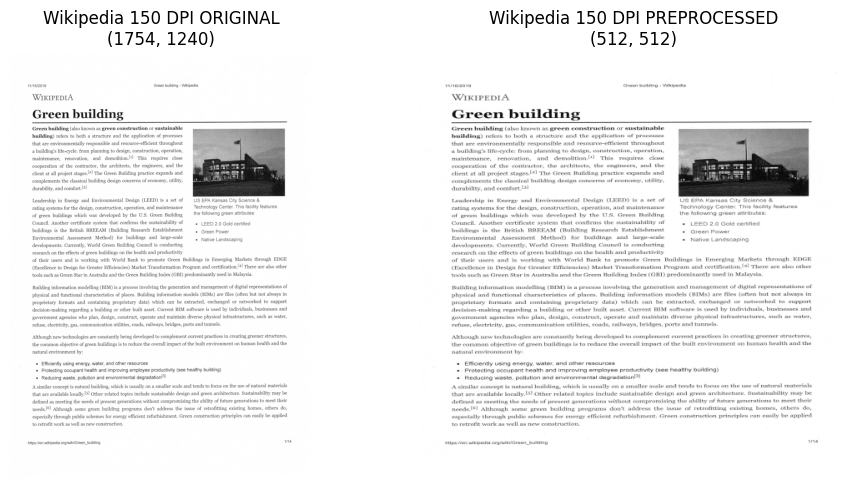

Info: {'path': '/content/drive/MyDrive/Tracefinder/Wikipedia/EpsonV39-1/150/s8_20.tif', 'orig_shape': (1754, 1240), 'final_shape': (512, 512)}
Raw min/max: 40 255
Proc min/max: 0.1882353 1.0
Random Wikipedia 300: /content/drive/MyDrive/Tracefinder/Wikipedia/EpsonV370-1/300/s6_79.tif


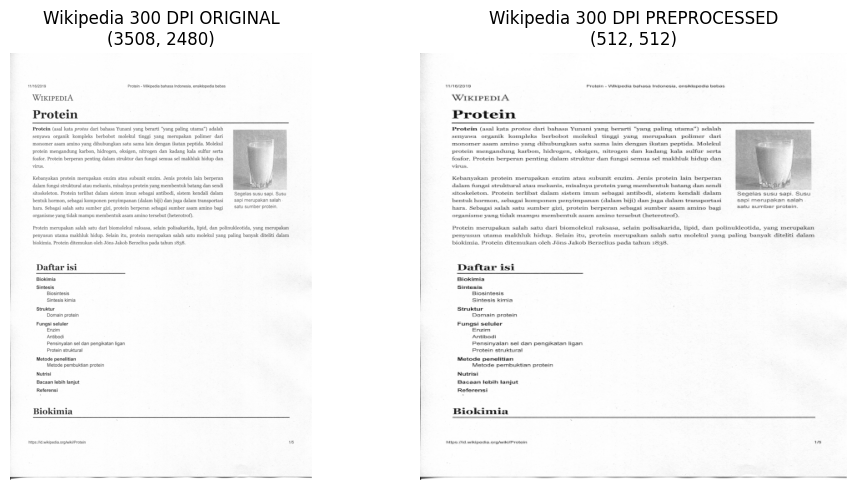

Info: {'path': '/content/drive/MyDrive/Tracefinder/Wikipedia/EpsonV370-1/300/s6_79.tif', 'orig_shape': (3508, 2480), 'final_shape': (512, 512)}
Raw min/max: 27 255
Proc min/max: 0.20392157 1.0


In [23]:


import os
import cv2
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import random

ROOT = "/content/drive/MyDrive/Tracefinder"
wikipedia_root = os.path.join(ROOT, "Wikipedia")



def load_gray_8bit(path):
    """Safely load image as grayscale uint8."""
    try:
        img = tifffile.imread(path)
    except Exception:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

    if img is None:
        raise ValueError(f"Could not read: {path}")

    # 16-bit → 8-bit
    if img.dtype == np.uint16:
        img = (img / 256).astype("uint8")

    # RGB/CMYK → grayscale
    if img.ndim == 3:
        if img.shape[2] in (3, 4):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img = img.mean(axis=2).astype("uint8")

    return img



IMG_SIZE = (512, 512)

def preprocess_wikipedia(path):
    """Preprocess Wikipedia: grayscale, resize to 512, normalize."""
    img = load_gray_8bit(path)
    h, w = img.shape

    img_resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img_norm = img_resized.astype("float32") / 255.0

    info = {
        "path": path,
        "orig_shape": (h, w),
        "final_shape": img_norm.shape
    }
    return img_norm, info



def get_random_wikipedia(dpi):
    all_paths = []

    for scanner_id in os.listdir(wikipedia_root):
        dpi_dir = os.path.join(wikipedia_root, scanner_id, dpi)
        if not os.path.isdir(dpi_dir):
            continue

        tif_files = [f for f in os.listdir(dpi_dir) if f.lower().endswith(".tif")]
        for f in tif_files:
            all_paths.append(os.path.join(dpi_dir, f))

    if not all_paths:
        raise ValueError(f"No Wikipedia images found for DPI={dpi}")

    return random.choice(all_paths)



def show_original_vs_wiki(path, title="Wikipedia"):
    img_raw = load_gray_8bit(path)
    img_proc, info = preprocess_wikipedia(path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_raw, cmap="gray")
    axes[0].set_title(f"{title} ORIGINAL\n{img_raw.shape}")
    axes[0].axis("off")

    axes[1].imshow(img_proc, cmap="gray")
    axes[1].set_title(f"{title} PREPROCESSED\n{img_proc.shape}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    print("Info:", info)
    print("Raw min/max:", img_raw.min(), img_raw.max())
    print("Proc min/max:", img_proc.min(), img_proc.max())





wiki_150 = get_random_wikipedia("150")
print("Random Wikipedia 150:", wiki_150)
show_original_vs_wiki(wiki_150, title="Wikipedia 150 DPI")


wiki_300 = get_random_wikipedia("300")
print("Random Wikipedia 300:", wiki_300)
show_original_vs_wiki(wiki_300, title="Wikipedia 300 DPI")


In [33]:


import os
import pandas as pd

ROOT = "/content/drive/MyDrive/Tracefinder"
wikipedia_root = os.path.join(ROOT, "Wikipedia")
wiki_csv_path = os.path.join(ROOT, "wikipedia_index.csv")


if "df_wiki" in globals():
    print("Using existing df_wiki in memory.")
else:
    if os.path.exists(wiki_csv_path):
        print("Loading existing wikipedia_index.csv")
        df_wiki = pd.read_csv(wiki_csv_path)
    else:
        print("wikipedia_index.csv not found. Rebuilding index from folders...")
        records = []
        for scanner_id in sorted(os.listdir(wikipedia_root)):
            scanner_dir = os.path.join(wikipedia_root, scanner_id)
            if not os.path.isdir(scanner_dir):
                continue

            for dpi in ["150", "300"]:
                dpi_dir = os.path.join(scanner_dir, dpi)
                if not os.path.isdir(dpi_dir):
                    continue

                for fname in sorted(os.listdir(dpi_dir)):
                    if fname.lower().endswith(".tif") or fname.lower().endswith(".tiff"):
                        path = os.path.join(dpi_dir, fname)
                        records.append({
                            "path": path,
                            "scanner_id": scanner_id,
                            "dpi": dpi,
                        })
        df_wiki = pd.DataFrame(records)

print("Columns currently in df_wiki:", df_wiki.columns.tolist())
print("Total rows:", len(df_wiki))

if "scanner_id" not in df_wiki.columns:
    raise RuntimeError("df_wiki does not have a 'scanner_id' column. Check your CSV or index building.")

if "label_id" not in df_wiki.columns:
    unique_scanners = sorted(df_wiki["scanner_id"].unique())
    scanner_to_label = {s: i for i, s in enumerate(unique_scanners)}
    print("\nScanner → label_id mapping:", scanner_to_label)

    df_wiki["label_id"] = df_wiki["scanner_id"].map(scanner_to_label)
else:
    print("\n'label_id' already exists in df_wiki. Showing mapping:")
    unique_scanners = sorted(df_wiki["scanner_id"].unique())
    scanner_to_label = {s: i for i, s in enumerate(unique_scanners)}
    print("Scanner → label_id mapping (from current data):", scanner_to_label)

df_wiki.to_csv(wiki_csv_path, index=False)
print("\n✅ Saved updated Wikipedia index with label_id to:", wiki_csv_path)

display(df_wiki.head())


Using existing df_wiki in memory.
Columns currently in df_wiki: ['path', 'scanner_id', 'dpi', 'label_id']
Total rows: 2368

'label_id' already exists in df_wiki. Showing mapping:
Scanner → label_id mapping (from current data): {'Canon120-1': 0, 'Canon120-2': 1, 'Canon220': 2, 'Canon9000-1': 3, 'Canon9000-2': 4, 'EpsonV370-1': 5, 'EpsonV370-2': 6, 'EpsonV39-1': 7, 'EpsonV39-2': 8, 'EpsonV550': 9, 'HP': 10}

✅ Saved updated Wikipedia index with label_id to: /content/drive/MyDrive/Tracefinder/wikipedia_index.csv


,path,scanner_id,dpi,label_id
0,/content/drive/MyDrive/Tracefinder/Wikipedia/C...,Canon120-1,150,0
1,/content/drive/MyDrive/Tracefinder/Wikipedia/C...,Canon120-1,150,0
2,/content/drive/MyDrive/Tracefinder/Wikipedia/C...,Canon120-1,150,0
3,/content/drive/MyDrive/Tracefinder/Wikipedia/C...,Canon120-1,150,0
4,/content/drive/MyDrive/Tracefinder/Wikipedia/C...,Canon120-1,150,0
